    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64
                 N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    53.362727    48.149091    25.616244    71.481779   
std      36.917334    32.985883    50.647931     5.063749    22.263812   
min       0.000000     5.000000     5.000000     8.825675    14.258040   
25%      21.000000    28.000000    20.000000    22.769375    60.261953   
50%      37

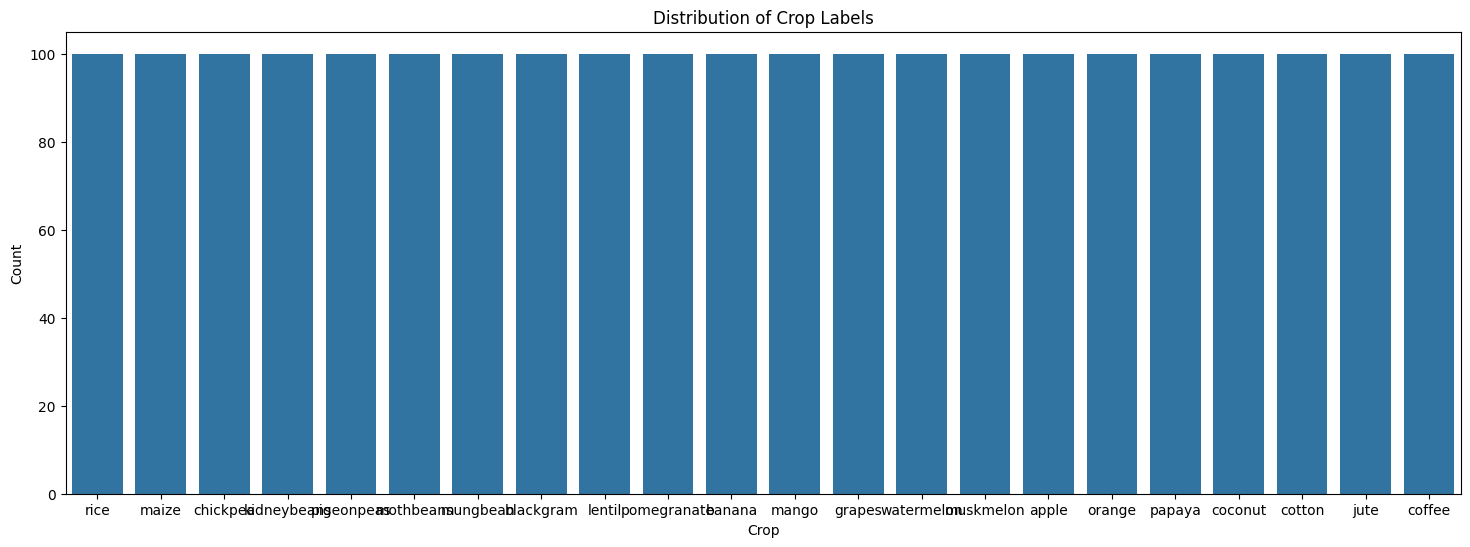

Epoch [10/100], Loss: 2.2652, Training Accuracy: 51.88%
Epoch [20/100], Loss: 1.7862, Training Accuracy: 70.74%
Epoch [30/100], Loss: 1.5846, Training Accuracy: 79.77%
Epoch [40/100], Loss: 1.4138, Training Accuracy: 85.68%
Epoch [50/100], Loss: 1.3249, Training Accuracy: 88.98%
Epoch [60/100], Loss: 1.2474, Training Accuracy: 90.68%
Epoch [70/100], Loss: 1.2062, Training Accuracy: 91.76%
Epoch [80/100], Loss: 1.1695, Training Accuracy: 92.73%
Epoch [90/100], Loss: 1.1496, Training Accuracy: 93.01%
Epoch [100/100], Loss: 1.1317, Training Accuracy: 93.30%
Accuracy on test set: 89.77%
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       0.95      1.00      0.98        21
   blackgram       1.00      0.75      0.86        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      0.93      0.96        27
      coffee       0.81      1.00      0.89        17
      cotton       0.77      1.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the dataset
df = pd.read_csv('Crop_recommendation.csv')

# Exploratory Data Analysis (EDA)
# Display the first few rows of the dataset
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())

# Visualize the distribution of the target variable
plt.figure(figsize=(18, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Crop Labels')
plt.xlabel('Crop')
plt.ylabel('Count')
plt.show()

# Preprocessing
# Encode categorical labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Split features and target variable
X = df.drop(columns=['label'])
y = df['label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.int64)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Adjust Model Architecture and Add Batch Normalization
class CropRecommendationModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(CropRecommendationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Define the model
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64
num_classes = len(label_encoder.classes_)
model = CropRecommendationModel(input_size, hidden_size1, hidden_size2, num_classes)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Calculate training accuracy
    _, predicted_train = torch.max(outputs, 1)
    train_accuracy = (predicted_train == y_train).sum().item() / len(y_train)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy*100:.2f}%')

# Evaluate the model on test set
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted_test = torch.max(outputs, 1)
    test_accuracy = (predicted_test == y_test).sum().item() / len(y_test)
    print(f'Accuracy on test set: {test_accuracy*100:.2f}%')

    # Generate classification report
    print(classification_report(y_test, predicted_test, target_names=label_encoder.classes_))

# Save the model
#torch.save(model.state_dict(), 'crop_recommendation_model.pth')
